# Experiments Adversarial

In [14]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [15]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torch.nn.functional as F
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.categorical import Categorical

import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

# Dataset

In [16]:
class MoonCircleDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = torch.tensor(make_circles(size, noise=0.05, factor=0.5)[0], dtype=torch.float)
        self.moons = torch.tensor(make_moons(size, noise=0.05)[0], dtype=torch.float)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

In [17]:
class OneVariateDataset(Dataset):
    def __init__(self, size, marg_x, marg_y):
        self.size = size
        self.x = marg_x.sample([size, 1])
        self.y = marg_y.sample([size, 1])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.x[idx], self.y[idx]

In [18]:
def visualize_GAN(gan, x, y):
    real_data = pd.DataFrame(x, columns=['x', 'y'])
    samples = pd.DataFrame(gan(y).detach().numpy(), columns=['x', 'y'])
    
    _, axs = plt.subplots(ncols=2, figsize=(8, 4))
    sns.kdeplot(real_data, x='x', y='y', fill=True, ax=axs[0])
    sns.kdeplot(samples, x='x', y='y', fill=True, color='r', ax=axs[1])
    plt.show()

In [19]:
def visualize(cond_p, cond_q, dataset):
    circles, moons = dataset[:1_000, :1_000]
    
    fake_circles = pd.DataFrame(cond_p(moons).detach().numpy(), columns=['x', 'y'])
    fake_moons = pd.DataFrame(cond_q(circles).detach().numpy(), columns=['x', 'y'])
    circles = pd.DataFrame(circles, columns=['x', 'y'])
    moons = pd.DataFrame(moons, columns=['x', 'y'])
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 4))
    sns.kdeplot(circles, x='x', y='y', fill=True, ax=axs[0][0])
    axs[0][0].set_title("Circles")
    sns.kdeplot(fake_circles, x='x', y='y', fill=True, color='r', ax=axs[0][1])
    axs[0][1].set_title("Fake Circles")
    sns.kdeplot(moons, x='x', y='y', fill=True, ax=axs[1][0])
    axs[1][0].set_title("Moons")
    sns.kdeplot(fake_moons, x='x', y='y', fill=True, color='r', ax=axs[1][1])
    axs[1][1].set_title("Fake Moons")
    plt.show()

## Model implementation

In [311]:
def get_simple_model(hiddens, activation=nn.ReLU()):
    assert len(hiddens) > 1
    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_), nn.BatchNorm1d(out_), activation])
    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
    return nn.Sequential(*modules)

In [418]:
# Define of divergence's conjugate function
class Conjugate(nn.Module):
    conjugates = {
        'forward_kl': lambda x: torch.exp(x - 1),
        'reverse_kl': lambda x: -1 - torch.log(-x),
        'js': lambda x: -torch.log(1 - torch.exp(x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.conjugates.keys() 
        self.conjugate = self.conjugates[divergence]

    def forward(self, x):
        return self.conjugate(x)

# Define of divergence's activation function
class Activation(nn.Module):
    activations = {
        'forward_kl': lambda x: x,
        'reverse_kl': lambda x: -torch.exp(-x),
        'js': lambda x: -torch.log(1 + torch.exp(-x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.activations.keys() 
        self.activation = self.activations[divergence]

    def forward(self, x):
        return self.activation(x)

In [419]:
class Conditional(nn.Module):
    def __init__(self, in_dim, latent_dim=2):
        super().__init__()
        
        self.in_dim = in_dim
        self.gen =  get_simple_model([latent_dim + in_dim, 256, 256, in_dim])
        self.latent_dist = lambda num: torch.normal(mean=0., std=1., size=(num, latent_dim))

    def forward(self, x):
        bs = x.shape[0]
        z_x = torch.cat([self.latent_dist(bs).to(x.device), x], dim=1)
        return self.gen(z_x)

    def init_weights(
            self, 
            gamma,
            epochs, 
            loader,
            lr_disc,
            lr_gen
        ):
        self._device = next(self.gen.parameters()).device
        self._disc = get_simple_model([2 * self.in_dim, 256, 256, 1], nn.LeakyReLU(0.1)).to(self._device)
        self._real_dist = lambda mean: torch.normal(mean=mean, std=gamma)
        self._criterion = nn.BCELoss()
        self._optim_disc = torch.optim.Adam(self._disc.parameters(), lr=lr_disc)
        self._optim_gen = torch.optim.Adam(self.gen.parameters(), lr=lr_gen)
        
        losses = {'loss_gen': [], 'loss_disc_real': [], 'loss_disc_fake': []}

        for epoch in tqdm(range(epochs)):
            total_disc_real, total_disc_fake = 0, 0
            total_gen = 0
            for x, _ in loader:
                x = x.to(self._device)
                loss_disc_real, loss_disc_fake = self._train_step_disc(x)
                loss_gen = self._train_step_gen(x)
                
                total_disc_real += loss_disc_real
                total_disc_fake += loss_disc_fake
                total_gen += loss_gen
            losses['loss_gen'].append(total_gen / len(loader))
            losses['loss_disc_real'].append(total_disc_real / len(loader))
            losses['loss_disc_fake'].append(total_disc_fake / len(loader))
            if epoch % 20 == 0:
                print(f"gen Loss: {losses['loss_gen'][-1]}, disc Real Loss: {losses['loss_disc_real'][-1]}, disc Fake Loss: {losses['loss_disc_fake'][-1]}")
        self.losses = losses

    def _train_step_gen(self, x):
        bs = x.shape[0]
        self._optim_gen.zero_grad()
        
        y_x = torch.cat([self(x), x], dim=1)
        loss = self._criterion(
            F.sigmoid(self._disc(y_x)), 
            torch.ones((bs, 1), device=self._device)
        )
        loss.backward()
        self._optim_gen.step()
        return loss.item()

    def _train_step_disc(self, x):
        bs = x.shape[0]
        self._optim_disc.zero_grad()
        
        y_x = torch.cat([self._real_dist(x), x], dim=1)
        loss_real = self._criterion(
            F.sigmoid(self._disc(y_x)), 
            torch.ones((bs, 1), device=self._device)
        )

        with torch.no_grad():
            y_x = torch.cat([self(x), x], dim=1)
        
        loss_fake = self._criterion(
            F.sigmoid(self._disc(y_x)), 
            torch.zeros((bs, 1), device=self._device)
        )

        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self._optim_disc.step()
        
        return loss_real.item(), loss_fake.item()
    
############## TEST ##################
test_in_dim = 2
test_latent_dim = 2
test_cond = Conditional(test_in_dim)

test_x = torch.ones((2, test_in_dim))
test_cond(test_x)
test_cond

Conditional(
  (gen): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [420]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, divergence='forward_kl'):
        super().__init__()
        self.in_dim = in_dim

        self.net = get_simple_model([2 * in_dim, 256, 256, 1],  nn.LeakyReLU(0.1))
        self.activation = Activation(divergence)
        self.conjugate = Conjugate(divergence)

    def forward(self, x, y, conjugate=False):
        x_y = torch.cat([x, y], dim=1)
        x_y = self.activation(self.net(x_y))
        return x_y if not conjugate else self.conjugate(x_y)

############## TEST ##################
test_in_dim = 2
test_disc = Discriminator(test_in_dim)

test_x = torch.rand((4, test_in_dim))
test_y = torch.rand((4, test_in_dim))
test_disc(test_x, test_y)
test_disc

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (activation): Activation()
  (conjugate): Conjugate()
)

In [430]:
class AdversarialIPFPTrainer:
    def __init__(self, batch_size, cond_p, cond_q, disc_b, disc_f, lr_gen=None, lr_disc=None):
        self.batch_size = batch_size
        self.dim  = cond_p.in_dim
        
        self.cond_p = cond_p # x|y
        self.cond_q = cond_q # y|x
        self.disc_b = disc_b
        self.disc_f = disc_f

        if lr_gen is None:
            lr_gen = {
                'forward': 1e-4,
                'backward': 1e-4,
            }
        if lr_disc is None:
            lr_disc = {
                'forward': 1e-4,
                'backward': 1e-4,
            }

        self.optim_gen = {
            'forward': torch.optim.Adam(cond_q.parameters(), lr=lr_gen['forward'], betas=(0.5, 0.999)),
            'backward': torch.optim.Adam(cond_p.parameters(), lr=lr_gen['backward'], betas=(0.5, 0.999))
        } 
        self.optim_disc = {
            'forward': torch.optim.Adam(disc_f.parameters(), lr=lr_disc['forward'], betas=(0.5, 0.999)),
            'backward': torch.optim.Adam(disc_b.parameters(), lr=lr_disc['backward'], betas=(0.5, 0.999)),
        } 
        
    def _backward_step(self, x, y):
        loss_cond = self._train_step_gen(y, self.cond_p, self.disc_b, self.optim_gen, step='backward')
        loss_disc_fixed, loss_disc_training = self._train_step_disc(y, x, self.cond_p, self.cond_q, self.disc_b, self.optim_disc, step='backward')
        return loss_cond, loss_disc_fixed, loss_disc_training

    def _forward_step(self, x, y):
        loss_cond = self._train_step_gen(x, self.cond_q, self.disc_f, self.optim_gen, step='forward')
        loss_disc_fixed, loss_disc_training = self._train_step_disc(x, y, self.cond_q, self.cond_p, self.disc_f, self.optim_disc, step='forward')
        return loss_cond, loss_disc_fixed, loss_disc_training
    
    def _train_step_gen(self, latent, cond, disc, optim, step):
        optim[step].zero_grad()

        # Generate fake samples
        generated = cond(latent)

        if step == 'backward':
            loss = disc(generated, latent).mean()
        else:
            loss = disc(latent, generated).mean()
        
        loss.backward()
        optim[step].step()
        return loss.detach().cpu().item()
    
    def _train_step_disc(self, latent1, latent2, cond, cond_fixed, disc, optim, step):
        optim[step].zero_grad()

        # calc training cond loss
        generated = cond(latent1)

        if step == 'backward':
            loss_training = disc(generated, latent1).mean() # В случае backward в Discriminator подается (y, x)
        else:
            loss_training = disc(latent1, generated).mean()

        # calc fixed cond loss
        with torch.no_grad():
            generated = cond_fixed(latent2)
            
        if step == 'backward':
            loss_fixed = disc(latent2, generated, conjugate=True).mean()
        else:
            loss_fixed = disc(generated, latent2, conjugate=True).mean()
        

        # combine
        loss = loss_fixed - loss_training
        loss.backward()
        optim[step].step()
            
        return -loss_fixed.detach().cpu().item(), loss_training.detach().cpu().item()

# One variate

In [504]:
# Models parameters
data_dim = 1
divergence='forward_kl'

conditional_q_fixed = Conditional(data_dim, latent_dim=1).to(device)

# Trainer and dataloader parameters
batch_size = 32


marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([0.5, 0.5], dtype=torch.float)), 
    Normal(torch.tensor([20, -20], dtype=torch.float), torch.tensor([0.5, 0.5], dtype=torch.float))
)
# marginal_y = Normal(5, 1)
dataset = OneVariateDataset(2_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
init_params = {
    'epochs': 80,
    'loader': dataloader,
    'gamma': 5.,
    'lr_disc': 1e-4, 
    'lr_gen': 4e-5,    
}
conditional_q_fixed.init_weights(**init_params)

  0%|          | 0/80 [00:00<?, ?it/s]

gen Loss: 0.7340352563630967, disc Real Loss: 0.6993380028104025, disc Fake Loss: 0.6593322101093474
gen Loss: 0.6985812395338028, disc Real Loss: 0.6991894973648919, disc Fake Loss: 0.6929765778874594
gen Loss: 0.694589806927575, disc Real Loss: 0.6931111131395612, disc Fake Loss: 0.6947863934532045
gen Loss: 0.6924254979406085, disc Real Loss: 0.6931023957237364, disc Fake Loss: 0.6942510150727772


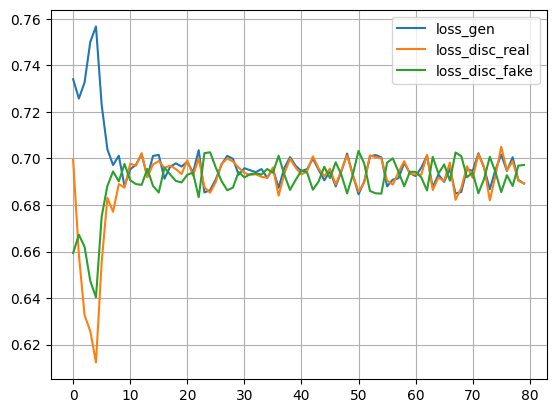

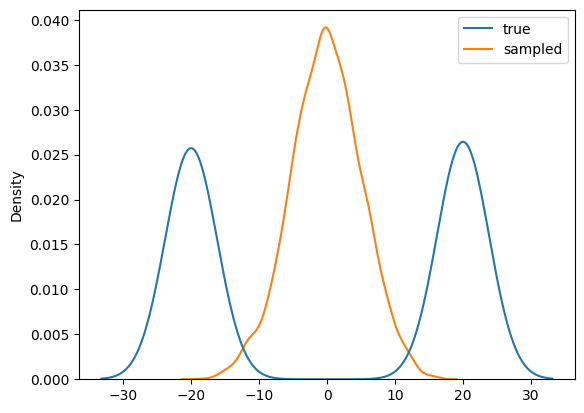

In [505]:
conditional_q_fixed.to('cpu')

plt.figure()
for key, value in conditional_q_fixed.losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.grid()
plt.legend()
plt.show()

n_samples = 4098
true_x = marginal_x.sample([n_samples, 1])
true_y = marginal_y.sample([n_samples, 1])

with torch.no_grad():
    sampled_y = conditional_q_fixed(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y)
# axs[0].set_title("Samples from conditional q(y|x)")

plt.show()

In [506]:
from copy import deepcopy

discriminator_backward = Discriminator(data_dim, divergence=divergence).to(device)
discriminator_forward = Discriminator(data_dim, divergence=divergence).to(device)

conditional_p = Conditional(data_dim, latent_dim=1).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 1e-4, 'backward': 1e-4},
    lr_gen={'forward': 1e-5, 'backward': 1e-5}
)

losses = {
    'cond_p': [], 
    'cond_q': [], 
    'disc_b_fixed': [], 
    'disc_f_fixed': [],
    'disc_b_training': [], 
    'disc_f_training': []
}

for epoch in range(100):
    print(f'======= Epoch {epoch} =======')
    total_loss_cond_p, total_loss_disc_b_fixed, total_loss_disc_b_training = 0, 0, 0
    for batch in dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_p, loss_disc_b_fixed, loss_disc_b_training = trainer._backward_step(x, y)
        total_loss_cond_p += loss_cond_p
        total_loss_disc_b_fixed += loss_disc_b_fixed
        total_loss_disc_b_training += loss_disc_b_training
    avg_loss_cond_p = total_loss_cond_p / len(dataloader)
    avg_loss_disc_b_fixed = total_loss_disc_b_fixed / len(dataloader)
    avg_loss_disc_b_training = total_loss_disc_b_training / len(dataloader)
    print(f'Backward cond_p: {avg_loss_cond_p}, disc_b_fixed: {avg_loss_disc_b_fixed}, disc_b_training: {avg_loss_disc_b_training}')
    
    total_loss_cond_q, total_loss_disc_f_fixed, total_loss_disc_f_training = 0, 0, 0
    for batch in dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        loss_cond_q, loss_disc_f_fixed, loss_disc_f_training = trainer._forward_step(x, y)
        total_loss_cond_q += loss_cond_q
        total_loss_disc_f_fixed += loss_disc_f_fixed
        total_loss_disc_f_training += loss_disc_f_training
    avg_loss_cond_q  = total_loss_cond_q / len(dataloader)
    avg_loss_disc_f_fixed = total_loss_disc_f_fixed / len(dataloader)
    avg_loss_disc_f_training = total_loss_disc_f_training / len(dataloader)
    print(f'Forward cond_q: {avg_loss_cond_q}, disc_f_fixed: {avg_loss_disc_f_fixed}, disc_f_training: {avg_loss_disc_f_training}')

    # хочу увидеть логи для бэквар и форвард отдельно, скорее всего внутренние шаги не оптимальны
    losses['cond_p'].append(avg_loss_cond_p)
    losses['cond_q'].append(avg_loss_cond_q)
    losses['disc_b_fixed'].append(avg_loss_disc_b_fixed)
    losses['disc_f_fixed'].append(avg_loss_disc_f_fixed)
    losses['disc_b_training'].append(avg_loss_disc_b_training)
    losses['disc_f_training'].append(avg_loss_disc_f_training)



    

======= Epoch 0 =======
Backward cond_p: 0.9398890156594534, disc_b_fixed: -0.7304174370235867, disc_b_training: 0.9393292078896175
Forward cond_q: 0.19232542626559734, disc_f_fixed: -0.4379625533308302, disc_f_training: 0.19436039765261942
======= Epoch 1 =======
Backward cond_p: 1.442495486092946, disc_b_fixed: -1.0141396513060918, disc_b_training: 1.4430414684235104
Forward cond_q: 0.5983614249834939, disc_f_fixed: -0.6796540845008123, disc_f_training: 0.6103119093274313
======= Epoch 2 =======
Backward cond_p: 1.7095132271448772, disc_b_fixed: -1.1580796090383378, disc_b_training: 1.7089647603413416
Forward cond_q: 0.74416260492234, disc_f_fixed: -0.764719617745233, disc_f_training: 0.7476677516150096
======= Epoch 3 =======
Backward cond_p: 1.8264047702153523, disc_b_fixed: -1.1997822296051752, disc_b_training: 1.8259498902729578
Forward cond_q: 0.8479696114857992, disc_f_fixed: -0.7792821081857833, disc_f_training: 0.8496323180577111
======= Epoch 4 =======
Backward cond_p: 1.904

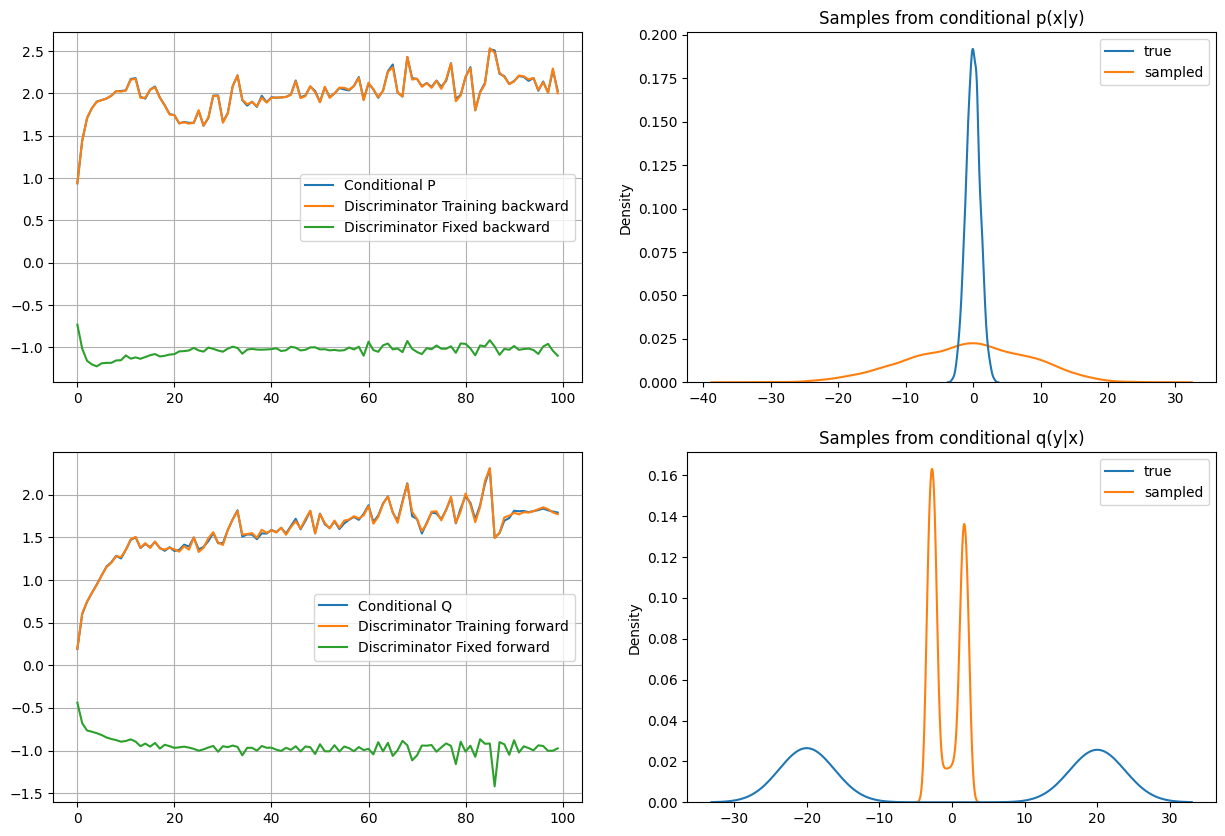

In [507]:
conditional_q.to('cpu')
conditional_p.to('cpu')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot losses
axs[0][0].plot(losses['cond_p'], label='Conditional P')
axs[0][0].plot(losses['disc_b_training'], label='Discriminator Training backward')
axs[0][0].plot(losses['disc_b_fixed'], label='Discriminator Fixed backward')

axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(losses['cond_q'], label='Conditional Q')
axs[1][0].plot(losses['disc_f_training'], label='Discriminator Training forward')
axs[1][0].plot(losses['disc_f_fixed'], label='Discriminator Fixed forward')

axs[1][0].grid()
axs[1][0].legend()

# Plot samples 
n_samples = 4098
true_x = marginal_x.sample([n_samples, 1]).cpu()
true_y = marginal_y.sample([n_samples, 1]).cpu()

conditional_q.eval()
sampled_y = conditional_q(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[1][1])
axs[1][1].set_title("Samples from conditional q(y|x)")

conditional_p.eval()
sampled_x = conditional_p(true_y).detach().numpy()
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[0][1])
axs[0][1].set_title("Samples from conditional p(x|y)")

plt.show()

# Two variate

In [455]:
# Models parameters
data_dim = 2
divergence='forward_kl'

conditional_q_fixed = Conditional(data_dim, latent_dim=2).to(device)

# Trainer and dataloader parameters
batch_size = 32

dataset = MoonCircleDataset(2_000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
init_params = {
    'epochs': 50,
    'loader': dataloader,
    'gamma': 3.,
    'lr_disc': 1e-4, 
    'lr_gen': 1e-5,    
}
conditional_q_fixed.init_weights(**init_params)

  0%|          | 0/50 [00:00<?, ?it/s]

gen Loss: 0.8524915519214812, disc Real Loss: 0.814313859220535, disc Fake Loss: 0.5643025376493969
gen Loss: 0.8211123299977136, disc Real Loss: 0.6041447860854012, disc Fake Loss: 0.5908309334800357
gen Loss: 0.6981812479004027, disc Real Loss: 0.6852669204984393, disc Fake Loss: 0.6944556690397716


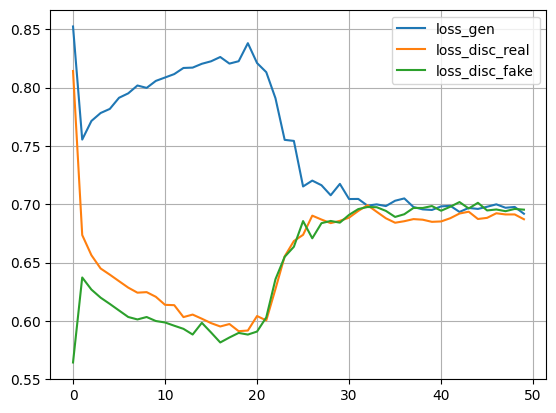

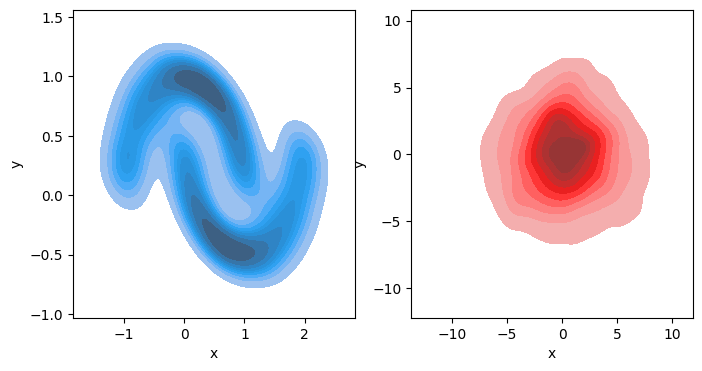

In [456]:
plt.figure()
for key, value in conditional_q_fixed.losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.grid()
plt.legend()
plt.show()
x, y = dataset[:]
visualize_GAN(conditional_q_fixed.to('cpu'), y, x)

In [462]:
from copy import deepcopy

discriminator_backward = Discriminator(data_dim, divergence=divergence).to(device)
discriminator_forward = Discriminator(data_dim, divergence=divergence).to(device)

conditional_p = Conditional(data_dim, latent_dim=2).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 1e-4, 'backward': 1e-4},
    lr_gen={'forward': 1e-5, 'backward': 1e-5}
)

losses = {
    'cond_p': [], 
    'cond_q': [], 
    'disc_b_fixed': [], 
    'disc_f_fixed': [],
    'disc_b_training': [], 
    'disc_f_training': []
}

for epoch in range(100):
    print(f'======= Epoch {epoch} =======')
    total_loss_cond_p, total_loss_disc_b_fixed, total_loss_disc_b_training = 0, 0, 0
    for batch in dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_p, loss_disc_b_fixed, loss_disc_b_training = trainer._backward_step(x, y)
        total_loss_cond_p += loss_cond_p
        total_loss_disc_b_fixed += loss_disc_b_fixed
        total_loss_disc_b_training += loss_disc_b_training
    avg_loss_cond_p = total_loss_cond_p / len(dataloader)
    avg_loss_disc_b_fixed = total_loss_disc_b_fixed / len(dataloader)
    avg_loss_disc_b_training = total_loss_disc_b_training / len(dataloader)
    print(f'Backward cond_p: {avg_loss_cond_p}, disc_b_fixed: {avg_loss_disc_b_fixed}, disc_b_training: {avg_loss_disc_b_training}')
    
    total_loss_cond_q, total_loss_disc_f_fixed, total_loss_disc_f_training = 0, 0, 0
    for batch in dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        loss_cond_q, loss_disc_f_fixed, loss_disc_f_training = trainer._forward_step(x, y)
        total_loss_cond_q += loss_cond_q
        total_loss_disc_f_fixed += loss_disc_f_fixed
        total_loss_disc_f_training += loss_disc_f_training
    avg_loss_cond_q  = total_loss_cond_q / len(dataloader)
    avg_loss_disc_f_fixed = total_loss_disc_f_fixed / len(dataloader)
    avg_loss_disc_f_training = total_loss_disc_f_training / len(dataloader)
    print(f'Forward cond_q: {avg_loss_cond_q}, disc_f_fixed: {avg_loss_disc_f_fixed}, disc_f_training: {avg_loss_disc_f_training}')

    # хочу увидеть логи для бэквар и форвард отдельно, скорее всего внутренние шаги не оптимальны
    losses['cond_p'].append(avg_loss_cond_p)
    losses['cond_q'].append(avg_loss_cond_q)
    losses['disc_b_fixed'].append(avg_loss_disc_b_fixed)
    losses['disc_f_fixed'].append(avg_loss_disc_f_fixed)
    losses['disc_b_training'].append(avg_loss_disc_b_training)
    losses['disc_f_training'].append(avg_loss_disc_f_training)

======= Epoch 0 =======
Backward cond_p: 0.5984005123849899, disc_b_fixed: -0.6212069817951748, disc_b_training: 0.5999347950731005
Forward cond_q: -0.012628582564906942, disc_f_fixed: -0.3515996677534921, disc_f_training: -0.012324960399714728
======= Epoch 1 =======
Backward cond_p: 1.0487982488813854, disc_b_fixed: -0.8799387623393347, disc_b_training: 1.0500959072794234
Forward cond_q: 0.5380120400398497, disc_f_fixed: -0.5720543809353359, disc_f_training: 0.5375030116429405
======= Epoch 2 =======
Backward cond_p: 1.230051702923245, disc_b_fixed: -0.9973710349627903, disc_b_training: 1.229748387185354
Forward cond_q: 0.8889627163372342, disc_f_fixed: -0.7658396032121446, disc_f_training: 0.8834414160440839
======= Epoch 3 =======
Backward cond_p: 1.2986470139215862, disc_b_fixed: -1.0373800699673001, disc_b_training: 1.2984097136391535
Forward cond_q: 1.0551966863965232, disc_f_fixed: -0.8968198233180575, disc_f_training: 1.0563430663139102
======= Epoch 4 =======
Backward cond_p:

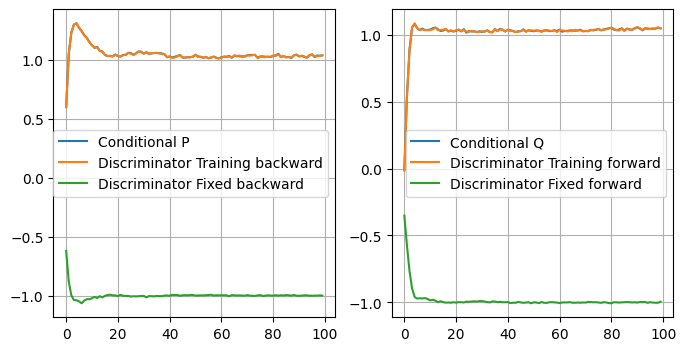

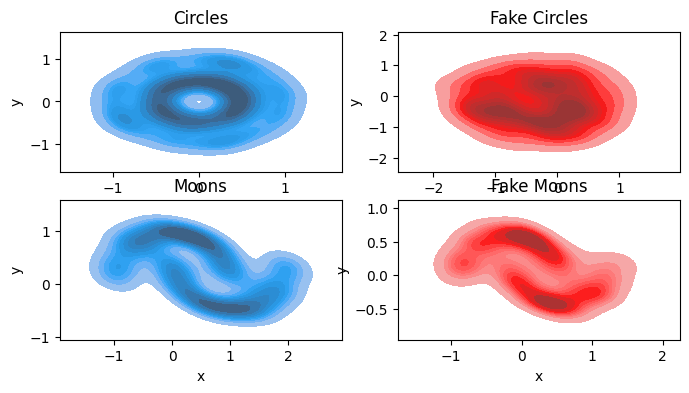

In [463]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# Plot losses

axs[0].plot(losses['cond_p'], label='Conditional P')
axs[0].plot(losses['disc_b_training'], label='Discriminator Training backward')
axs[0].plot(losses['disc_b_fixed'], label='Discriminator Fixed backward')
axs[0].grid()
axs[0].legend()

axs[1].plot(losses['cond_q'], label='Conditional Q')
axs[1].plot(losses['disc_f_training'], label='Discriminator Training forward')
axs[1].plot(losses['disc_f_fixed'], label='Discriminator Fixed forward')
axs[1].grid()
axs[1].legend()

# plt.grid()
# plt.legend0()
visualize(conditional_p.cpu(), conditional_q.cpu(), dataset)